In [65]:
# import packages
from pyproj import CRS, Transformer
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import cartopy.crs as ccrs
import icepyx as ipx 
import pandas as pd
import numpy as np
import h5py
import glob
import os
import pandas as pd
import cmocean

In [66]:
data_dir='data/' # data in this folder was subsetted using NSIDC's data downloader

In [67]:
# define utility functions
def multiple_is2_requests(earthdata_email, earthdata_uid, 
                          data_dir, requests, subset, download, visualize, email):
    """
    function to loop through series of requests to get data
    """
    for req in requests:
        region = ipx.Query(req['short_name'], req['spatial_extent'], req['date_range'])
        if download==True:
            region.earthdata_login(earthdata_uid, earthdata_email)
            region.download_granules(data_dir,subset=subset,email=email)
        print(region.dataset)
        print(region.dates)
        print(region.start_time)
        print(region.end_time)
        print(region.dataset_version)
        print(region.spatial_extent)
        if visualize:
            region.visualize_spatial_extent()

def read_field(group, field):
    """
    generic field-reading function
    """
    data=np.array(group[field])
    bad=(data==group[field].attrs['_FillValue'])
    data[bad]=np.NaN
    return data

def read_ATL11(filename, pair):
    """
    ATL11 reader
    """
    with h5py.File(filename,'r') as h5f:
        latitude=read_field(h5f[pair],'latitude')
        longitude=read_field(h5f[pair],'longitude')
        h_corr=read_field(h5f[pair],'h_corr')
        h_corr_sigma=read_field(h5f[pair],'h_corr_sigma')
        h_corr_sigma_s=read_field(h5f[pair],'h_corr_sigma_systematic')
    # return the values
    return latitude, longitude, h_corr, np.sqrt(h_corr_sigma**2+h_corr_sigma_s**2)

def ps2ll(x, y):
    """
    Transform coordinates from Antarctic Polar Stereograph
    to geodetic (lon, lat) coordinates
    lon, lat = ps2ll(x, y)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    xy_to_ll = Transformer.from_crs(crs_xy, crs_ll, always_xy = True)
    lon, lat = xy_to_ll.transform(x, y)
    return lon, lat

def ll2ps(lon, lat):
    """
    Transform coordinates from geodetic coordinates (lon, lat)
    to Antarctic Polar Stereograph coordinates (x, y)
    x, y = ll2ps(lon, lat)
    """
    crs_ll = CRS("EPSG:4326")
    crs_xy = CRS("EPSG:3031")
    ll_to_xy = Transformer.from_crs(crs_ll, crs_xy, always_xy = True)
    x, y = ll_to_xy.transform(lon, lat)
    return x, y

In [68]:
# grab ATL11 files
files=glob.glob(os.path.join(data_dir, 'ATL11*.h5'))

# create empty lists
lat=[]
lon=[]
h_corr=[]
sigma_h=[]

# fill lists
for file in files:
    try:
        for pair in ['pt1','pt2','pt3']:
            lats, lons, hh, ss=read_ATL11(file, pair)
            lat += [lats]
            lon += [lons]
            h_corr += [hh]
            sigma_h += [ss]
    except Exception as E:
        pass
    
# concatenate lists
lon=np.concatenate(lon)
lat=np.concatenate(lat)
h_corr=np.concatenate(h_corr, axis=0)
sigma_h=np.concatenate(sigma_h, axis=0)

In [69]:
# the NSIDC subsetter sucks. Re-subset to the window you were looking for
lon_sub=lon[(lon>=-26)*(lon<=-18)*(lat>=-80.45)*(lat<=-79.2)]   
lat_sub=lat[(lon>=-26)*(lon<=-18)*(lat>=-80.45)*(lat<=-79.2)]
h_sub=h_corr[(lon>=-26)*(lon<=-18)*(lat>=-80.45)*(lat<=-79.2),:] 

# transform geodetic lon, lat to polar stereographic x, y
x, y = ll2ps(lon_sub,lat_sub)

In [70]:
dh=h_sub[:,5]-h_sub[:,0] # cycle 8 minus cycle 3

# load the outline for Slessor23
outline='/Users/siegfried/Documents/manuscripts/accepted/2018_siegfried_lakesextended/data_archive/active_lake_outlines/xy/Slessor_23.xy'
outl=pd.read_csv(outline, delimiter='\t', header=0, index_col=False, names=['x','y'])

In [71]:
# define limits you'll use
xl=-433000
xh=-383000
yl=1005000
yh=1055000

# dump the max dh in the window you are looking at since you'll use this number in the paper
max(dh[(x>=xl)*(x<=xh)*(y>=yl)*(y<=yh)])

11.71051

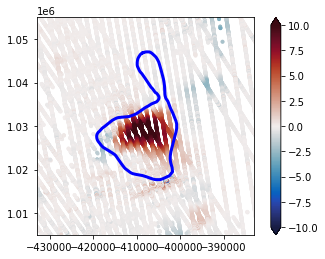

In [77]:
# just take a look at the data---we'll plot in GMT later (add pyGMT code to the end some day)
fig, ax = plt.subplots(1,1)
sc = ax.scatter(x,y,c=dh, s=15, vmin=-10, vmax=10, cmap=cmocean.cm.balance, edgecolors='none')
ax.plot(outl['x'],outl['y'],color ='b',linewidth=3)
ax.set_xlim(xl,xh)
ax.set_ylim(yl,yh)
hb = fig.colorbar(sc,ax=ax,extend='both',extendfrac=0.0375,drawedges=False,fraction=0.036, pad=0.05)
ax.set_aspect('equal')
plt.show()

In [22]:
# save the data using pandas (easy does it). Need to uncomment out the actual save line to make it work
out = pd.DataFrame({'x': x, 'y': y, 'dz': dh})
####out.to_csv('data/sless_is2.xyz', header = False, index = False, na_rep='nan')